# Anomaly detection in financial data
## 1. Gather Data

### Data Collection Process

The stock price data for a list of financial assets is collected using the `yfinance` package, which retrieves historical market data from Yahoo Finance. The following steps were performed to collect the data:

1. **Assets Selected**: A list of financial assets was defined, consisting of major financial institutions:
   - JPMorgan Chase & Co. (JPM)
   - Goldman Sachs Group Inc. (GS)
   - Morgan Stanley (MS)
   - BlackRock Inc. (BLK)
   - Citigroup Inc. (C)

2. **Date Range**: The data was collected for the period from January 1, 2018, to November 30, 2023.

3. **Data Download**: The adjusted closing prices for the selected assets were retrieved using the `yf.download` function, which allows downloading historical stock data. The `'Adj Close'` column is used to account for stock splits and dividend payments, providing an accurate representation of the stock's value over time.

4. **Date Formatting**: The `Date` column, which is included in the downloaded data, is converted into a `datetime` format for easy handling.

5. **Indexing**: The `Date` column is then set as the index of the DataFrame, enabling time-based analysis and manipulation.

The result is a DataFrame containing the adjusted closing prices for each asset over the specified date range.

Here is a preview of the first few rows of the collected data:

In [ ]:
import yfinance as yf 
import pandas as pd 

assets = ['JPM', 'GS', 'MS', 'BLK', 'C'] 
start_date = '2018-01-01' 
end_date = '2023-11-30' 
stocks = yf.download(assets, start=start_date, end=end_date)['Adj Close']
# Convert the Date column to datetime format
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Set the Date column as the index
stocks.set_index('Date', inplace=True)

# Display the first few rows of the DataFrame
stocks.head()

,BLK,C,GS,JPM,MS
Date,,,,,
2018-01-02,429.839417,59.538162,221.021774,89.109085,42.931217
2018-01-03,434.374573,59.722324,218.964294,89.199875,43.046375
2018-01-04,440.108826,60.458935,222.024582,90.477730,43.704460
2018-01-05,443.858612,60.378891,220.892120,89.896881,43.688011
2018-01-08,447.169189,59.674274,217.684845,90.029648,43.507042


## 2. Data Pre-processing

### 2.1. Handling Missing Values
The descriptive analysis of the stocks DataFrame reveals that each column contains 1,488 rows, indicating that there are no missing values in the dataset. Therefore, no further handling of missing data is required.

### 2.2. Descriptive Statistics of Stock Prices

- **Mean**: The average stock price for each asset is as follows:
  - BLK: \$567.8
  - C: \$52.1
  - GS: \$256.4
  - JPM: \$114.1
  - MS: \$61.0
- **Standard Deviation (Std)**: This measures the amount of variation in stock prices. 
  - BLK has the highest standard deviation (\$152.8), suggesting the most variability.
  - MS has the lowest standard deviation (\$21.6), indicating less variability.
- **Min**: The minimum observed price for each stock is:
  - BLK: \$294.3
  - MS: \$24.2
  This shows the range of stock prices observed during the period.
- **25% (Q1)**: The 25th percentile, indicating that 25% of the stock prices are below this value. For example:
  - 25% of BLK prices are below \$429.8.
- **50% (Median)**: The median stock price represents the middle value in the distribution. For example:
  - The median price for BLK is \$571.5.
- **75% (Q3)**: The 75th percentile, indicating that 75% of the prices are below this value. For example:
  - 75% of BLK prices are below \$677.8.
- **Max**: The maximum observed price for BLK is \$902.3, indicating the highest price recorded for this stock.


In [2]:
# Descriptive Analysis of Stock Price Data
stocks.describe().round(1)

,BLK,C,GS,JPM,MS
count,1488.0,1488.0,1488.0,1488.0,1488.0
mean,567.8,52.1,256.4,114.1,61.0
std,152.8,8.7,72.2,22.9,21.6
min,294.3,30.0,121.5,69.3,24.2
25%,429.8,44.4,188.6,93.0,40.6
50%,571.5,53.0,233.6,110.7,57.3
75%,677.8,58.9,321.0,136.4,81.4
max,902.3,71.0,393.0,158.9,99.9


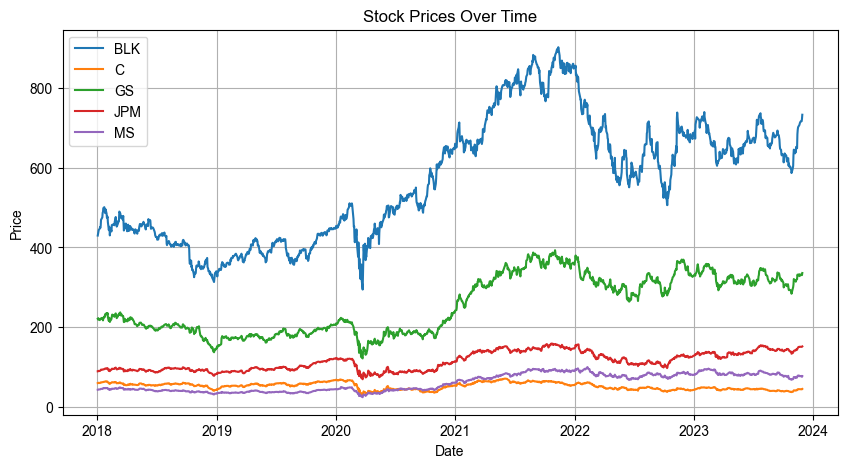

In [3]:

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Function to plot stock prices
def plot_time_series(data, title="Stock Prices Over Time"):
    """
    Plots the stock prices over time for multiple stocks from a given DataFrame.

    Parameters:
    data (pandas.DataFrame): DataFrame containing the stock prices with dates as the index 
                             and stock tickers as the column names.
    title (str): Title of the plot. Default is "Stock Prices Over Time".

    Returns:
    None: The function saves the plot as a .jpg file and displays it.
    
    The plot shows stock prices for all columns in the DataFrame against the dates.
    The resulting image is saved in the 'Figs' directory as 'stock price over time.jpg'.
    """
    plt.figure(figsize=(10, 5))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig('Figs/stock price over time.jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Plot the time series data
plot_time_series(stocks, title="Stock Prices Over Time")

### 2.3. Data Visualization and Preprocessing

Visualizing the stock price movements helps in understanding the data characteristics. A plot of the five selected assets over time reveals trends and seasonality, which can complicate anomaly detection. While decomposition methods can remove these patterns, a simpler approach is to compute the percentage change in the daily closing price for each stock:

$
\delta_i = 100 \times \frac{x_i - x_{i-1}}{x_{i-1}}
$

Where $ x_i $ is the price vector of $ p $ stocks on day $ i $, and $ x_{i-1} $ is the price on the previous day. Missing values in $ \delta_i $ are addressed using the Carry Forward method, replacing any missing value with the most recent non-missing value.

The percentage change data from $ n $ days forms an $ n \times p $ matrix, $ \Delta $, which is a multivariate time series. To improve anomaly detection, the data is rescaled. Both scaling and normalization are beneficial, but normalization is preferred in this case due to the use of distance-based algorithms and statistical methods.

- **Scaling**: Transforms data to a specific range (e.g., [0, 1]) and is useful for algorithms sensitive to scale, like neural networks.
- **Normalization**: Standardizes data to have a mean of 0 and a standard deviation of 1, making it suitable for algorithms that assume normally distributed data or where feature scale matters, like linear regression or clustering.

Given the analysis involves distance-based and statistical methods, normalizing $ \Delta(t) $ is the preferred approach.


In [4]:
import numpy as np
np.random.seed(42)

N,d = stocks.shape
delta_ns = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                    columns=stocks.columns, index=stocks.iloc[1:].index)
delta_ns = delta_ns.ffill()

from sklearn.preprocessing import StandardScaler
# Get dimensions of delta_ns (_ns stands for not standardized)
N, d = delta_ns.shape

# Standardize the data
scaler = StandardScaler()
delta_standardized_values = scaler.fit_transform(delta_ns)

# Create a new DataFrame with the same index and columns as the original delta
delta = pd.DataFrame(delta_standardized_values, index=delta_ns.index, columns=delta_ns.columns)

# Display the resulting DataFrame
delta.head()

,BLK,C,GS,JPM,MS
Date,,,,,
2018-01-03,0.510370,0.129088,-0.488670,0.024604,0.095517
2018-01-04,0.645635,0.525409,0.673503,0.713576,0.680612
2018-01-05,0.406730,-0.060355,-0.278630,-0.360537,-0.046459
2018-01-08,0.352555,-0.504077,-0.748738,0.048318,-0.221260
2018-01-09,0.400822,0.445277,0.398138,0.234319,0.330823


## 3. Visual Inspection
### 3.1 Pair Plot
Following presents the pair plot for the percentage changes in the daily closing prices of the five assets. Each scatter plot within the matrix shows the relationship between two different assets, while the diagonal elements display the histograms of each asset's percentage changes.
The pair plot indicates that there are strong linear relationships between the percentage changes of different assets, as evidenced by the tight clustering of points along the diagonals in the scatter plots. This suggests that the assets' price movements are correlated. The histograms along the diagonal reveal the distribution of each asset's percentage changes, which appear to be roughly normal but with some deviations, particularly in the tails.

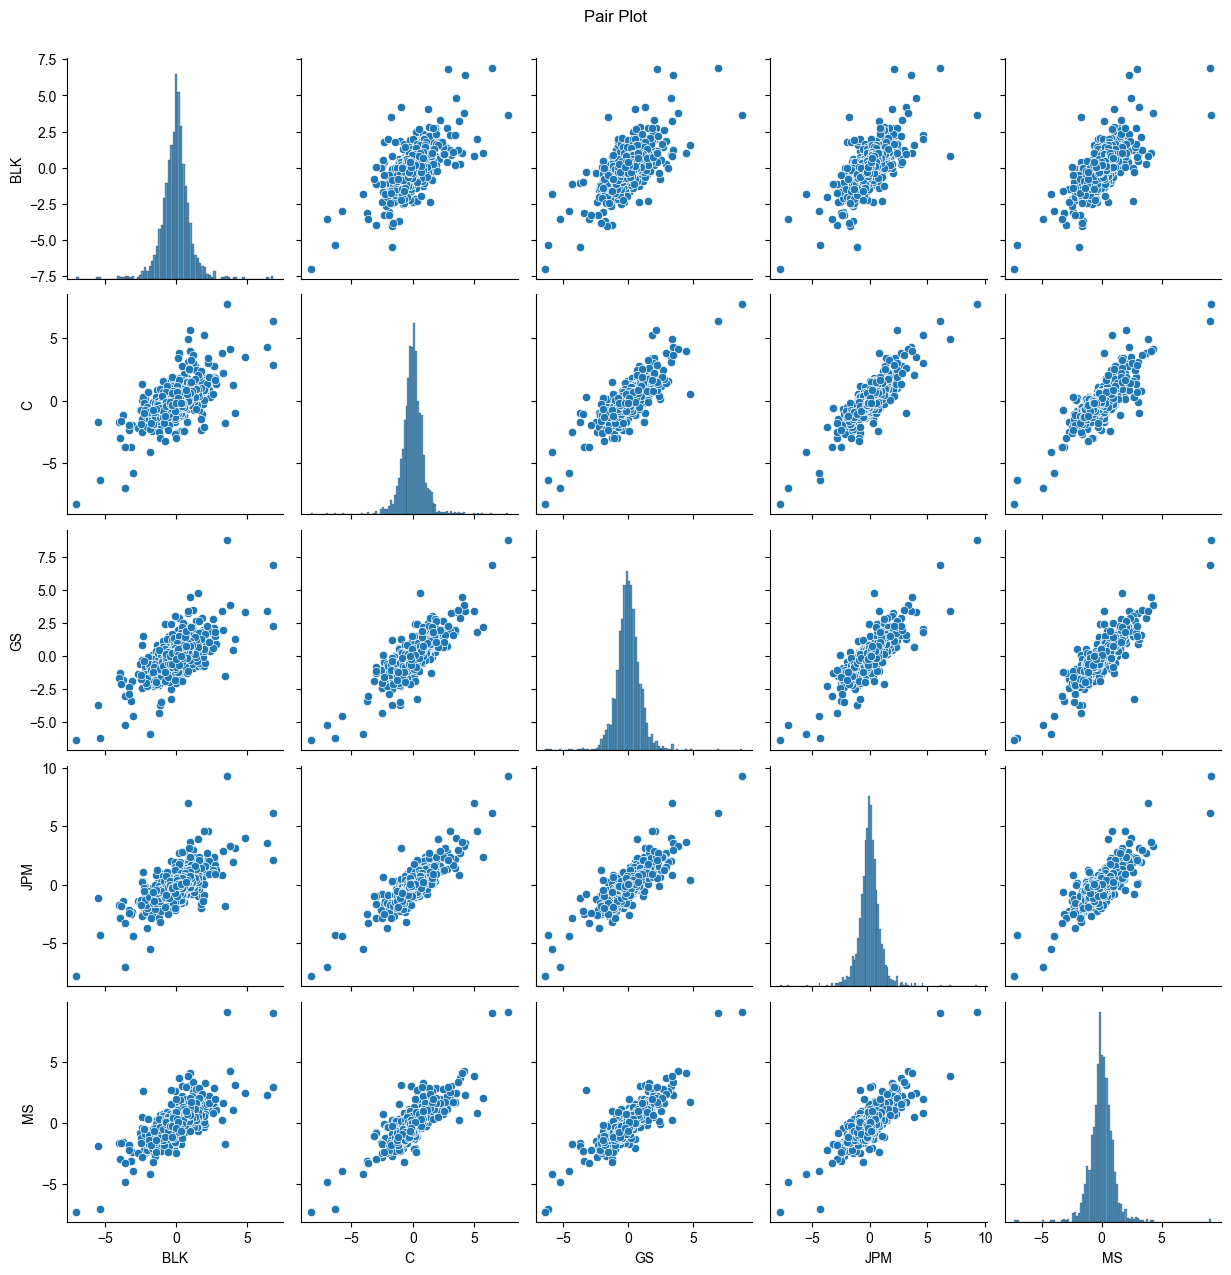

In [5]:
import seaborn as sns

sns.pairplot(delta)
plt.suptitle('Pair Plot', y=1.02)
plt.savefig('Figs/pair plot.jpg', dpi=300, bbox_inches='tight')
plt.show()


### 3.2 Q-Q Plot: 
Figure below shows the Q-Q plots for the percentage changes in the daily closing prices of the 5 assets. These plots compare the quantiles of the observed data to the quantiles of a normal distribution. The red line represents the theoretical quantiles from a standard normal distribution.

The Q-Q plots for all five assets show a similar pattern: most of the data points lie along the red line, indicating that the percentage changes in daily closing prices are approximately normally distributed in the central region of the distribution. However, deviations from the red line are observed at the tails, suggesting the presence of outliers and heavy tails in the distribution. These deviations are especially pronounced for extreme values, indicating that the data might have more extreme changes than what is expected under a normal distribution. This observation is critical for anomaly detection as it highlights the potential for rare but significant deviations that need to be accounted for in the analysis.

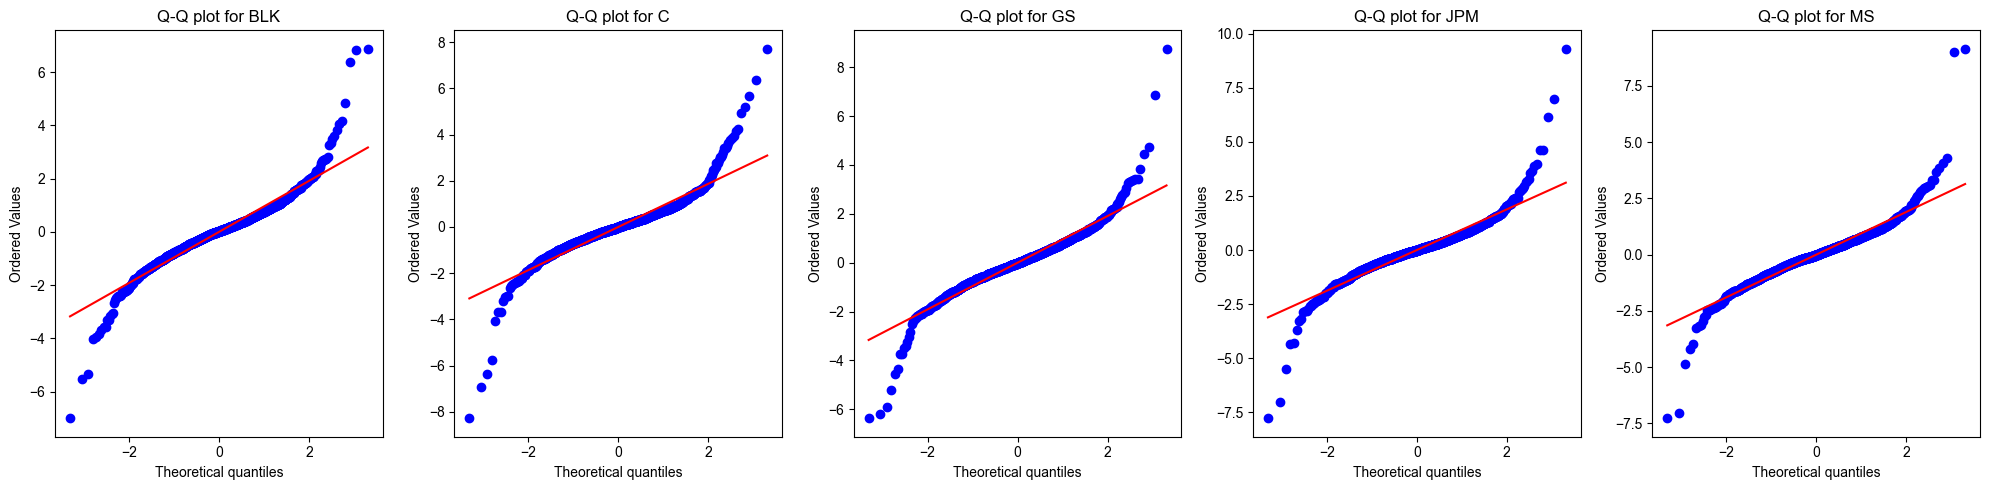

In [6]:
import scipy.stats as stats

# Number of columns in delta
num_columns = len(delta.columns)

# Create a 1x5 grid for subplots
fig, axs = plt.subplots(1, num_columns, figsize=(20, 5))

# Q-Q plot for each column
for i, column in enumerate(delta.columns):
    stats.probplot(delta[column], dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot for {column}')

# Adjust layout
plt.tight_layout()
plt.savefig('Figs/qq plot.jpg', dpi=300, bbox_inches='tight')
plt.show()


### 3.3. Skewness and Kurtosis Analysis
Following displays the skewness and kurtosis values for the percentage changes in the daily closing prices of the five assets. Skewness measures the asymmetry of the distribution, while kurtosis indicates the presence of outliers and the peakedness of the distribution. From the table, it can be observed that all assets exhibit positive skewness, with MS having the highest skewness value, suggesting a longer tail on the right side of the distribution. In terms of kurtosis, all assets show high values, significantly greater than 3 (which is the kurtosis of a normal distribution), indicating the presence of heavy tails or outliers. Particularly, JPM and MS have the highest kurtosis values, which suggests that their distributions are more prone to extreme values compared to the other assets.

In [7]:
# Skewness and Kurtosis for each column
for column in delta.columns:
    skew = delta[column].skew()
    kurtosis = delta[column].kurtosis()
    print(f'{column} skewness: {skew}, kurtosis: {kurtosis}')

BLK skewness: 0.16207482742884413, kurtosis: 8.048017672375314
C skewness: 0.06489036013918956, kurtosis: 12.295330320029052
GS skewness: 0.19182672190601605, kurtosis: 9.861177519197371
JPM skewness: 0.37862965560901124, kurtosis: 13.277020938776005
MS skewness: 0.5435995904316695, kurtosis: 13.495197575820022


### 3.4. Key Insights from Visual Inspection:

- **BLK:** Nearly symmetric distribution with very heavy tails.
- **C:** Nearly symmetric distribution with extremely heavy tails.
- **GS:** Slightly right-skewed distribution with very heavy tails.
- **JPM:** Noticeably right-skewed distribution with extremely heavy tails.
- **MS:** More pronounced right-skewed distribution with extremely heavy tails.

These results indicate that while the distributions are somewhat symmetric, they exhibit heavy tails and sharp peaks, implying a higher likelihood of extreme values compared to a normal distribution.


## 4. Anomaly Detection Algorithms
### 4.1 IQR Method
The Interquartile Range (IQR) method is a statistical approach used to detect anomalies in the data. The IQR measures the statistical dispersion and is calculated as the difference between the third quartile ($Q3$) and the first quartile ($Q1$):

$
\text{IQR} = Q3 - Q1
$

Where:
- $Q1$ is the first quartile (25th percentile),
- $Q3$ is the third quartile (75th percentile).

Anomalies are identified as data points that lie outside a specified range defined by the IQR. The range is typically set as:

$
\text{Lower Bound} = Q1 - k \cdot \text{IQR}
$
$
\text{Upper Bound} = Q3 + k \cdot \text{IQR}
$

Where $k$ is a constant that controls the sensitivity of anomaly detection. In this implementation, $k$ is set to 4, meaning that any data point outside four times the IQR from the quartiles is considered an anomaly.

The anomalies detected using the IQR method are shown in table and marked with red vertical dashed lines in the Figure.


In [8]:
# Function to show the anomalies in price data
def plot_anomalies(data, anomaly_indices, title, save_loc):
    """
    Plots the price data and highlights anomalies by marking them with vertical red dashed lines.

    Parameters:
    data (pandas.DataFrame): DataFrame containing the price data, with dates as the index and 
                             price values for each column.
    anomaly_indices (list): A list of indices where anomalies occur in the data. 
                             These indices will be marked on the plot with vertical red dashed lines.
    title (str): The title of the plot.
    save_loc (str): The file location where the plot image will be saved.

    Returns:
    None: The function saves the plot as an image file at the specified location and displays it.
    
    The plot displays the price data for all columns and highlights the anomaly points with vertical red dashed lines.
    """
    plt.figure(figsize=(10, 5))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
        for idx in anomaly_indices:
            plt.axvline(x=idx, color='red', linestyle='--', linewidth=0.1)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    plt.show()


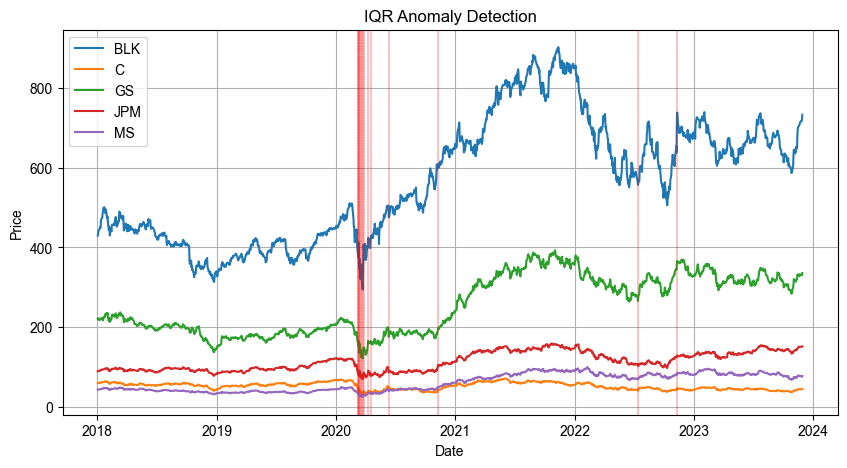

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9
2020-03-26,406.2,39.0,149.2,86.0,31.1


In [29]:
# Calculate IQR and detect anomalies
def detect_anomalies_iqr(data):
    """
    Detects anomalies in the given DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    data (pandas.DataFrame): DataFrame containing numerical columns with date or time as the index. 
                              The function assumes the DataFrame has a 'Date' column, which will be ignored during anomaly detection.

    Returns:
    pandas.DataFrame: A DataFrame with the same index as the input `data` but with Boolean values indicating anomalies.
                       Each column corresponds to the respective column in `data`, with `True` indicating an anomaly and `False` indicating normal data.

    The anomalies are detected by calculating the IQR for each column and identifying values that lie beyond 
    4 times the IQR from the first and third quartiles (lower and upper bounds).
    """
    anomalies = pd.DataFrame(index=data.index)
    for column in data.columns:
        if column != 'Date':
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 4.4 * IQR
            upper_bound = Q3 + 4.4 * IQR
            anomalies[column] = (data[column] < lower_bound) | (data[column] > upper_bound)
    return anomalies


# Apply IQR method to each column in delta matrix
anomalies = detect_anomalies_iqr(delta[['BLK', 'C', 'GS', 'JPM', 'MS']])

# Add anomaly column to delta DataFrame
delta_iqr = delta.copy()
delta_iqr['Anomaly'] = anomalies.any(axis=1)

iqr_result_indx = delta_iqr.loc[delta_iqr['Anomaly']==True].index



# Plot anomalies detected by IQR method
plot_anomalies(stocks, iqr_result_indx, title="IQR Anomaly Detection" , save_loc = 'Figs/iqr anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(iqr_result_indx)].round(1)


### 4.2. Z-score and Modified Z-score for Anomaly Detection

The Z-score method is used to calculate how many standard deviations a data point is from the mean:

$
Z = \frac{X - \mu}{\sigma}
$

Where:
- $X$ is the data point,
- $\mu$ is the mean,
- $\sigma$ is the standard deviation.

This method assumes that the data follows a normal distribution. However, if the data is not normally distributed, the mean and standard deviation become unreliable, leading to inaccurate Z-scores and poor anomaly detection.

To overcome this, non-parametric methods like the rolling median and Median Absolute Deviation (MAD) are used, which do not assume a specific distribution and are more robust for anomaly detection in financial time series data.

For an input matrix $\Delta$ of dimensions $n \times p$ (where the $i$-th row is $\delta_i$ representing percentage price changes for $p$ stocks at time $i$), the following metrics are defined:

- **Rolling Median (window size $w$)**:

$
\text{Rolling Median}(\delta_i) = \text{median}(\delta_{i-w+1}, \delta_{i-w+2}, \ldots, \delta_i)
$

- **Median Absolute Deviation (MAD)**:

$
\text{MAD} = \text{median}(|\delta_i - \text{median}(\delta)|)
$

Where $\delta$ is the set of percentage price changes for a stock within a window, and $\delta_i$ is an individual data point.

The **Modified Z-score** for a data point $\delta_i$ is calculated using the rolling median and MAD:

$
\text{Modified Z-Score}(\delta_i) = \frac{1}{Q_3} \cdot \frac{\delta_i - \text{Rolling Median}(\delta_i)}{\text{MAD}(\delta_i)}
$

Anomalies are detected by setting a threshold on the absolute value of the modified Z-score. The steps for anomaly detection using rolling median and MAD are:

1. Calculate the rolling median for each column.
2. Calculate the rolling MAD for each column.
3. Compute the modified Z-score for each data point.
4. Mark data points with a modified Z-score above the threshold as anomalies.

The anomalies detected using this method are shown and marked in below Table and Figure.


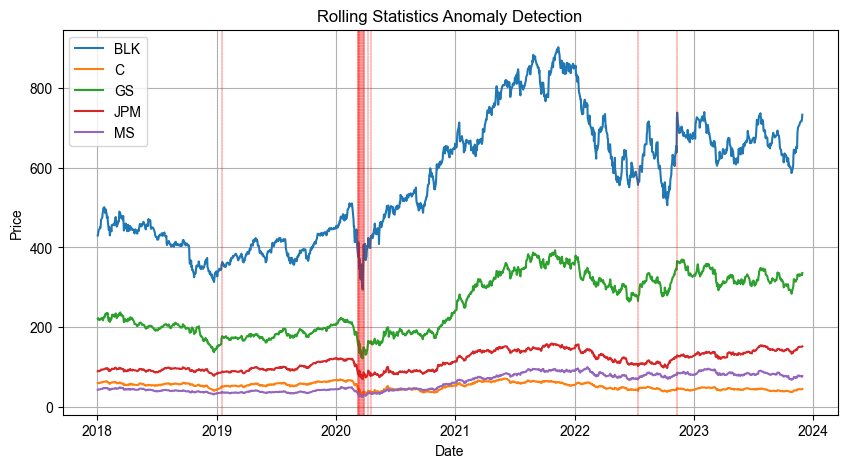

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [28]:
# Set rolling window size and modified Z-score threshold
window_size = 200
modified_z_score_threshold = 6.35  

# Function to detect anomalies using rolling median and MAD
def detect_anomalies_rolling_median_mad(data, window, z_thresh):
    """
    Detects anomalies in the given DataFrame using a rolling median and the Median Absolute Deviation (MAD) method.

    Parameters:
    data (pandas.DataFrame): DataFrame containing numerical columns with date or time as the index.
                              The function applies rolling median and MAD for anomaly detection on each column.
    window (int): The size of the rolling window to compute the median and MAD.
    z_thresh (float): The threshold value for the modified z-scores. Points with a modified z-score greater than this threshold are considered anomalies.

    Returns:
    pandas.DataFrame: A DataFrame with the same index as the input `data` but with Boolean values indicating anomalies.
                       Each column corresponds to the respective column in `data`, with `True` indicating an anomaly and `False` indicating normal data.

    The anomalies are detected by calculating the rolling median and MAD for each column, then computing the modified z-scores 
    using these values. Anomalies are identified where the absolute value of the modified z-score exceeds the specified threshold (`z_thresh`).
    """
    anomalies = pd.DataFrame(index=data.index)
    for column in data.columns:
        rolling_median = data[column].rolling(window=window).median()
        rolling_mad = data[column].rolling(window=window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
        modified_z_scores = 0.6745 * (data[column] - rolling_median) / rolling_mad
        anomalies[column] = np.abs(modified_z_scores) > z_thresh
    return anomalies


# Apply rolling median and MAD method to each stock column
anomalies = detect_anomalies_rolling_median_mad(delta, window_size, modified_z_score_threshold)

# Add anomaly column to delta DataFrame
delta_rolling_z = delta.copy()
delta_rolling_z['Anomaly'] = anomalies.any(axis=1)

mad_result_indx = delta_rolling_z.loc[delta_rolling_z['Anomaly']==True].index

# Plot anomalies detected by IQR method
plot_anomalies(stocks, mad_result_indx, title="Rolling Statistics Anomaly Detection" , save_loc = 'Figs/rolling statistics anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(mad_result_indx)].round(1)

### 4.3. A Parametric Anomaly Detection Model
To detect anomalies in a multivariate time series dataset $ \Delta $, the **Mahalanobis distance** is used, which accounts for correlations between variables. Given a dataset $ \Delta $ with $ n $ observations and $ p $ variables:

$
\Delta = [\mathbf{\delta}_1, \mathbf{\delta}_2, \ldots, \mathbf{\delta}_n]^T
$

Where each $ \mathbf{\delta}_i $ is a $ p $-dimensional vector.

1. **Covariance Matrix**: The covariance matrix $ \mathbf{\Sigma} $ is calculated as:

$
\mathbf{\Sigma} = \frac{1}{n-1} \sum_{i=1}^n (\mathbf{\delta}_i - \mathbf{\mu}) (\mathbf{\delta}_i - \mathbf{\mu})^T
$

Where $ \mathbf{\mu} $ is the mean vector:

$
\mathbf{\mu} = \frac{1}{n} \sum_{i=1}^n \mathbf{\delta}_i
$

2. **Mahalanobis Distance**: The Mahalanobis distance for an observation $ \mathbf{\delta}_i $ from the mean vector $ \mathbf{\mu} $ is defined as:

$
D_M(\mathbf{\delta_i}) = \sqrt{(\mathbf{\delta_i} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{\delta_i} - \mathbf{\mu})}
$

This distance measures how many standard deviations $ \mathbf{\delta_i} $ is away from the mean $ \mathbf{\mu} $, considering the correlations between variables.

3. **Threshold for Anomalies**: To determine the threshold for anomalies, we use the chi-square distribution. The squared Mahalanobis distance follows a chi-square distribution with $ p $ degrees of freedom:

$
D_M^2 \sim \chi^2(p)
$

The threshold is set as the 99th percentile of the chi-square distribution:

$
\text{threshold} = \chi^2_{0.99}(p)
$

Any observation with a Mahalanobis distance squared greater than this threshold is considered an anomaly.

Anomalies detected using the Mahalanobis distance method are shown in below Table and Figure.


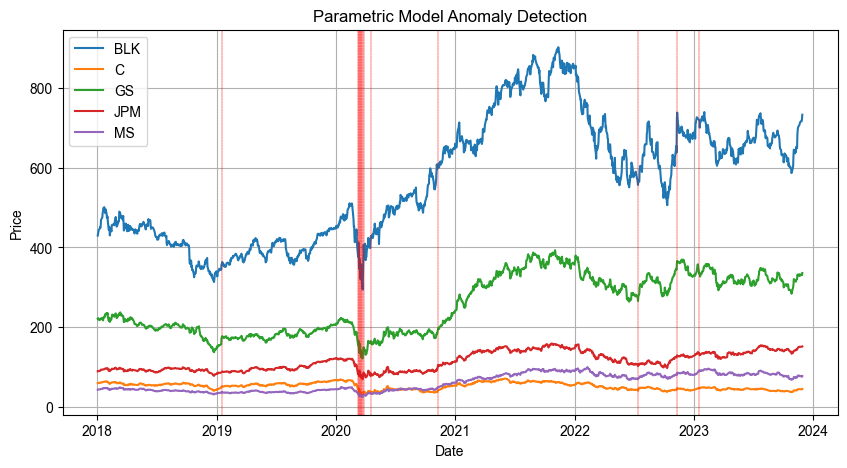

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [11]:
from scipy.spatial import distance

# Step 1: Calculate the covariance matrix and its inverse
cov_matrix = np.cov(delta, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Step 2: Compute the Mahalanobis distance for each observation
mean_distr = delta.mean(axis=0).values
mahalanobis_distances = delta.apply(lambda row: distance.mahalanobis(row, mean_distr, inv_cov_matrix), axis=1)

delta_maha = delta.copy()

# Add Mahalanobis distances to the DataFrame
delta_maha['Mahalanobis_Dist'] = mahalanobis_distances

# Step 3: Determine anomalies based on a threshold
# Using the 99th percentile of the Mahalanobis distances as the threshold
threshold = mahalanobis_distances.quantile(0.99)
delta_maha['Anomaly'] = delta_maha['Mahalanobis_Dist'] > threshold


parametric_model_result_inx = delta_maha.loc[delta_maha['Anomaly']==True].index

# Plot anomalies detected by parametric model
plot_anomalies(stocks, parametric_model_result_inx, title="Parametric Model Anomaly Detection" , save_loc = 'Figs/parametric model anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(parametric_model_result_inx)].round(1)

### 4.4. Vector Autoregressive (VAR) 
Vector Autoregression (VAR) is a statistical model that captures the linear interdependencies among multiple time series. It can be used for both forecasting and anomaly detection by analyzing forecast errors (residuals). The steps involved in the VAR anomaly detection process are as follows:

1. **Data Preparation**: The data must be stationary for the VAR model to be applied. In this case study, stationarity is achieved by calculating the $ \Delta $ matrix, a $ n \times p $ matrix where $ n $ is the number of historical data points and $ p $ is the number of stock prices.

2. **Fitting the VAR Model**: The VAR model of order $ q $ is defined as:

$
Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \ldots + A_q Y_{t-q} + \epsilon_t
$

Where:
- $ c $ is a vector of constants.
- $ A_1, A_2, \ldots, A_q $ are coefficient matrices.
- $ \epsilon_t $ is a vector of white noise error terms.

The optimal lag length $ q $ is selected using an information criterion such as the Akaike Information Criterion (AIC).

3. **Forecasting**: The fitted VAR model is used to forecast future values:

$
\hat{Y}_{t+h} = c + A_1 \hat{Y}_{t+h-1} + A_2 \hat{Y}_{t+h-2} + \ldots + A_q \hat{Y}_{t+h-q}
$

Where $ \hat{Y}_{t+h} $ is the forecasted value at time $ t+h $.

4. **Residuals and Anomaly Detection**: The residuals (forecast errors) are calculated as:

$
\epsilon_t = Y_t - \hat{Y}_t
$

The 99th percentile threshold for each column of residuals is computed:

$
\text{Threshold}_j = \text{Percentile}_{99}(|\epsilon_{t,j}|)
$

Anomalies are detected by comparing the absolute residuals to the thresholds:

$
\text{Anomaly}_{t,j} = 
\begin{cases} 
1 & \text{if } |\epsilon_{t,j}| > \text{Threshold}_j \\
0 & \text{otherwise}
\end{cases}
$

Anomalies detected using the VAR model are shown in below Table and Figure.


C:\Users\bbanita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


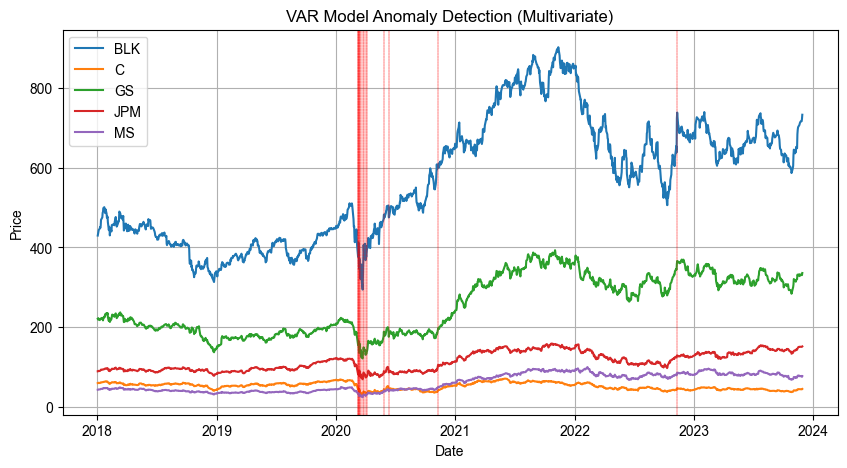

,BLK,C,GS,JPM,MS,Mahalanobis_Distance,Anomaly
Date,,,,,,,
2020-03-09,-3.586094,-6.939335,-5.210517,-7.041415,-4.843656,25.328561,True
2020-03-10,4.842787,3.511320,3.308900,3.994642,2.446524,16.345852,True
2020-03-11,-3.144789,-3.699787,-3.397451,-2.465247,-3.119485,14.377473,True
2020-03-12,-5.327538,-6.362102,-6.182645,-4.296018,-7.028545,26.591482,True
2020-03-13,3.613794,7.709607,8.750364,9.297916,9.147515,35.527489,True
2020-03-16,-6.996975,-8.280429,-6.365348,-7.776294,-7.269921,33.365678,True
2020-03-18,-1.796367,-4.073976,-5.890499,-5.478493,-4.204939,19.814396,True
2020-03-24,6.874047,6.383016,6.865129,6.130152,9.000552,32.078269,True
2020-03-26,6.395660,4.258622,3.405618,3.578583,2.319816,17.959712,True


In [34]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance

# Assume `delta` is your DataFrame with relevant columns
data = delta[['BLK', 'C', 'GS', 'JPM', 'MS']]

# Ensure stationarity and other preprocessing if necessary (differencing, etc.)
# Fit the VAR model
model = VAR(data)
results = model.fit(maxlags=15, ic='aic')

# Forecast the next values (one-step ahead forecasting for simplicity)
forecast = results.forecast(data.values[-results.k_ar:], steps=len(data))
forecast_df = pd.DataFrame(forecast, index=data.index, columns=data.columns)

# Calculate residuals (forecast errors)
residuals = data - forecast_df

# Calculate covariance matrix of residuals for Mahalanobis distance
cov = EmpiricalCovariance().fit(residuals)

# Calculate Mahalanobis distance for each row
mahalanobis_distances = residuals.apply(lambda row: mahalanobis(row, np.mean(residuals, axis=0), cov.covariance_), axis=1)

# Set a threshold for anomaly detection (e.g., 99th percentile of the distances)
threshold = np.percentile(mahalanobis_distances, 99)

# Identify anomalies where the Mahalanobis distance exceeds the threshold
anomalies = mahalanobis_distances > threshold

# Create a DataFrame for anomalies
anomalies_df = pd.DataFrame({
    'Mahalanobis_Distance': mahalanobis_distances,
    'Anomaly': anomalies
}, index=data.index)

# Filter dates where anomalies occurred
var_result_indx = anomalies_df[anomalies_df['Anomaly']].index

# Create a merged DataFrame to show original values and anomaly status
merged_df = pd.merge(
    data.loc[data.index.isin(var_result_indx)],
    anomalies_df.loc[var_result_indx],
    left_index=True,
    right_index=True,
    how='inner'
)

# Plotting the anomalies
plot_anomalies(stocks, var_result_indx, title="VAR Model Anomaly Detection (Multivariate)", save_loc='Figs/var_model_anomalies_multivariate.jpg')

# Display the numerical values of the anomalies
merged_df

### 4.5. Using Kalman Filter for Anomaly Detection
The Kalman filter is used for estimating the state of a linear dynamic system in the presence of noise. In this case, it is applied to detect anomalies in the time series data of stock price changes. The input matrix $ \Delta $ is an $ n \times p $ matrix where each column represents the percentage price change for a stock.

1. **Prediction Step**: The Kalman filter predicts the next state and its uncertainty using the current state estimate and the process model:

$
\begin{aligned}
\text{State prediction:} \quad & \mathbf{x}_{k|k-1} = \mathbf{F} \mathbf{x}_{k-1|k-1} \\
\text{Covariance prediction:} \quad & \mathbf{P}_{k|k-1} = \mathbf{F} \mathbf{P}_{k-1|k-1} \mathbf{F}^\top + \mathbf{Q}
\end{aligned}
$

2. **Update Step**: The prediction is corrected by incorporating new measurements:

$
\begin{aligned}
\text{Innovation (residual):} \quad & \mathbf{y}_k = \mathbf{z}_k - \mathbf{H} \mathbf{x}_{k|k-1} \\
\text{Innovation covariance:} \quad & \mathbf{S}_k = \mathbf{H} \mathbf{P}_{k|k-1} \mathbf{H}^\top + \mathbf{R} \\
\text{Kalman gain:} \quad & \mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^\top \mathbf{S}_k^{-1} \\
\text{State update:} \quad & \mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + \mathbf{K}_k \mathbf{y}_k \\
\text{Covariance update:} \quad & \mathbf{P}_{k|k} = \left( \mathbf{I} - \mathbf{K}_k \mathbf{H} \right) \mathbf{P}_{k|k-1}
\end{aligned}
$

3. **Mahalanobis Distance**: The Mahalanobis distance is used to measure how far the residual is from the mean residuals, considering the covariance structure of the residuals:

$
D_M(\mathbf{r}) = \sqrt{ (\mathbf{r} - \boldsymbol{\mu}_r)^\top \mathbf{C}_r^{-1} (\mathbf{r} - \boldsymbol{\mu}_r) }
$

Where:
- $ \mathbf{r} $ is the residual.
- $ \boldsymbol{\mu}_r $ is the mean of the residuals.
- $ \mathbf{C}_r $ is the covariance matrix of the residuals.

4. **Anomaly Detection**: Anomalies are identified by comparing the Mahalanobis distance to a threshold, which is set based on the 99th percentile:

$
\text{Anomaly} = \begin{cases} 
1 & \text{if } D_M > \text{threshold} \\
0 & \text{otherwise}
\end{cases}
$

Price anomalies detected by the Kalman Filter are shown in below Table and Figure.




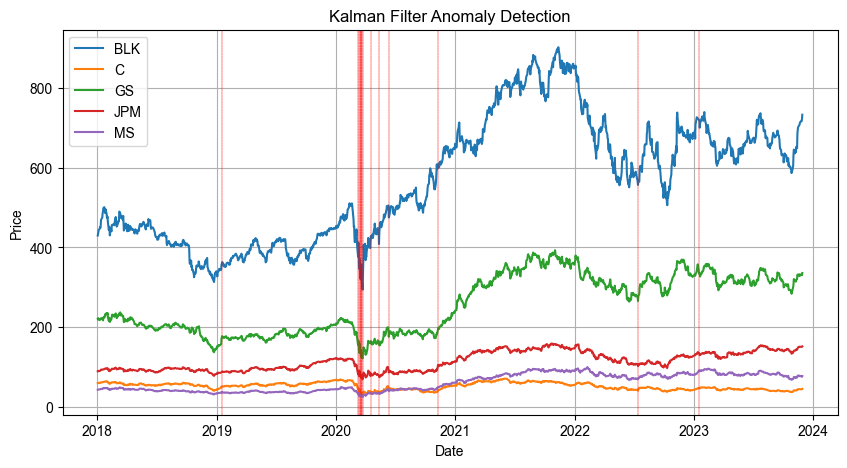

,BLK,C,GS,JPM,MS
Date,,,,,
2019-01-16,357.6,50.9,172.7,87.3,37.4
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-19,357.2,33.6,134.5,74.8,26.9
2020-03-20,318.9,32.2,124.6,73.2,25.8
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [13]:
from filterpy.kalman import KalmanFilter

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=5, dim_z=5)
kf.x = np.zeros(5)  # initial state (location and velocity)
kf.F = np.eye(5)  # state transition matrix
kf.H = np.eye(5)  # observation matrix
kf.P *= 1000.  # covariance matrix
kf.R = np.eye(5)  # measurement noise
kf.Q = np.eye(5)  # process noise

# Apply the Kalman Filter
predictions = []
residuals = []

for i in range(len(delta)):
    z = delta[['BLK', 'C', 'GS', 'JPM', 'MS']].iloc[i].values
    kf.predict()
    kf.update(z)
    predictions.append(kf.x)
    residuals.append(z - kf.x)

predictions = np.array(predictions)
residuals = np.array(residuals)

# Calculate Mahalanobis distance for residuals
mean_residuals = np.mean(residuals, axis=0)
cov_residuals = np.cov(residuals, rowvar=False)
inv_cov_residuals = np.linalg.inv(cov_residuals)

mahalanobis_distances = np.array([
    np.sqrt((res - mean_residuals).T @ inv_cov_residuals @ (res - mean_residuals))
    for res in residuals
])

# Determine anomalies based on 99th percentile
threshold = np.percentile(mahalanobis_distances, 99)
anomalies = mahalanobis_distances > threshold


# Add anomaly column to delta DataFrame

delta_kf = delta.copy()
delta_kf['Mahalanobis_Dist'] = mahalanobis_distances
delta_kf['Anomaly'] = anomalies


kalman_result_indx = delta_kf.loc[delta_kf['Anomaly']==True].index

# Plot anomalies detected by Kalman Filter
plot_anomalies(stocks, kalman_result_indx, title="Kalman Filter Anomaly Detection" , save_loc = 'Figs/kalman filter anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(kalman_result_indx)].round(1)


### 4.6. K-Nearest Neighbors (KNN) for Anomaly Detection

K-Nearest Neighbors (KNN) is a non-parametric algorithm used for anomaly detection by examining the distances between data points in a multi-dimensional space. It classifies data points based on their proximity to neighbors in the feature space, with the assumption that points close to each other are similar.

1. **Anomaly Score**: The anomaly score for a data point $ \delta_i $ is computed as the maximum distance to its $ k $-nearest neighbors:

$
\text{Anomaly score}(\delta_i) = \max_{j \in \{1, \ldots, k\}} d(\delta_i, \delta_j)
$

Where $ d(\delta_i, \delta_j) $ is the Euclidean distance between $ \delta_i $ and its $ j $-th nearest neighbor.

2. **Threshold**: The data points are ranked based on their anomaly scores, and the 99th percentile threshold is used to identify anomalies. Higher anomaly scores indicate potential outliers.

Anomalies detected using the KNN method are shown in below Table and Figure.


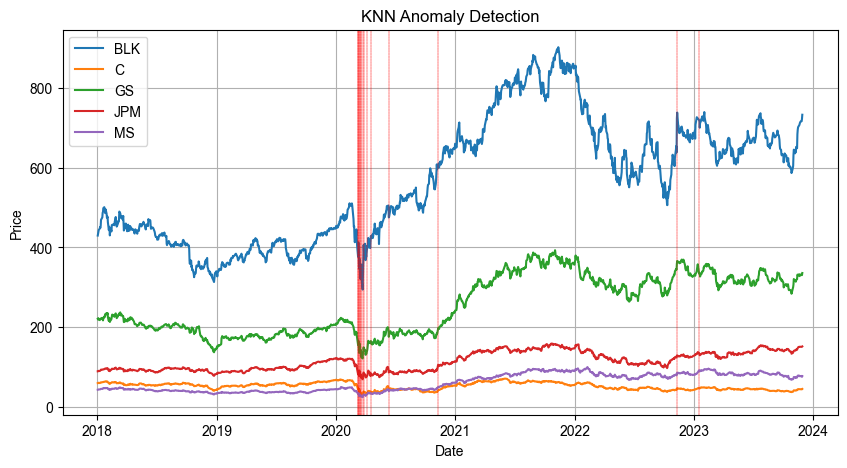

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-17,347.7,34.1,142.8,82.2,29.4
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-24,334.2,34.4,138.2,77.5,28.9
2020-03-26,406.2,39.0,149.2,86.0,31.1


In [14]:
from sklearn.neighbors import NearestNeighbors

# Define the number of nearest neighbors
knn = 4

# Fit the NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=knn, metric='euclidean').fit(delta.to_numpy())
distances, indices = nbrs.kneighbors(delta.to_numpy())

# Calculate anomaly scores
anomaly_score = distances[:, knn-1]
anom = pd.DataFrame(anomaly_score, index=delta.index, columns=['Anomaly score'])

# Concatenate the anomaly scores with the original DataFrame
result = pd.concat((delta, anom), axis=1)

# Set the threshold to 99 percent and find the anomalies indexes 
knn_indx = result.nlargest(round(len(delta)*0.01), 'Anomaly score').index


# Plot anomalies detected by KNN model
plot_anomalies(stocks, knn_indx, title="KNN Anomaly Detection" , save_loc = 'Figs/KNN anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(knn_indx)].round(1)


### 4.7. Anomaly Detection Using Isolation Forest

Isolation Forest is an unsupervised algorithm designed for anomaly detection. It isolates anomalies by randomly selecting features and split values, making it efficient for detecting outliers in a dataset. The process involves building an ensemble of isolation trees (iTrees), each constructed through recursive partitioning.

1. **Key Steps**:
   - **Random Subsampling**: A random subset of the data is selected.
   - **Recursive Partitioning**: An isolation tree is built by recursively selecting features and split values until data points are isolated or a maximum depth is reached.
   - **Path Length Calculation**: The path length is the number of splits needed to isolate a data point, with anomalies requiring fewer splits.

2. **Anomaly Score**: The anomaly score is calculated as:

$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$

where $ E(h(x)) $ is the average path length, and $ c(n) $ is the average path length of unsuccessful searches in a Binary Search Tree.

Anomalies detected using the Isolation Forest method are shown in below Table and Figure.




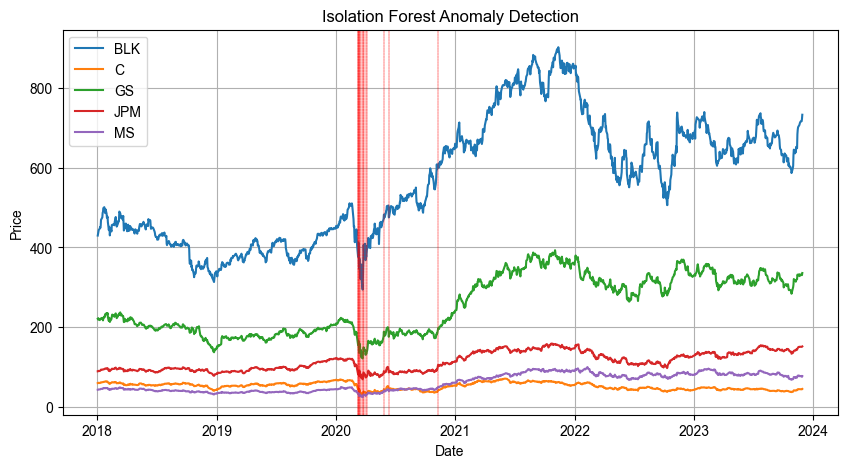

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-10,412.6,47.1,165.9,88.2,34.4
2020-03-11,387.4,43.0,154.7,84.1,32.1
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-23,294.3,30.0,121.5,69.3,24.2
2020-03-24,334.2,34.4,138.2,77.5,28.9


In [15]:
from sklearn.ensemble import IsolationForest
# Fit the Isolation Forest model
clf = IsolationForest(contamination=0.01, random_state=42)
delta_isolation_forest = delta.copy()
delta_isolation_forest['Anomaly'] = clf.fit_predict(delta[['BLK', 'C', 'GS', 'JPM', 'MS']])

# Convert anomaly labels to Boolean (1 for anomaly, -1 for normal)
delta_isolation_forest['Anomaly'] = delta_isolation_forest['Anomaly'] == -1

if_indx = delta_isolation_forest.loc[delta_isolation_forest['Anomaly']==True].index

# Plot anomalies detected by Isolation Forest model
plot_anomalies(stocks, if_indx, title="Isolation Forest Anomaly Detection" , save_loc = 'Figs/isolation forest anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(if_indx)].round(1)

### 4.8. Dense Model (Autoencoder) for Anomaly Detection

An autoencoder is a neural network used to learn efficient representations of input data, consisting of an encoder (compressing data) and a decoder (reconstructing data). Autoencoders are effective for anomaly detection because they can learn normal patterns in data and identify deviations as anomalies.

1. **Autoencoder Architecture**:
   - **Encoder**: Compresses input data into a lower-dimensional representation.
   - **Decoder**: Reconstructs the data from the compressed form.
   - **Objective**: Minimize the mean squared error (MSE) between the input data $ \Delta $ and the reconstructed data $ \hat{\Delta} $.

2. **Mathematical Formulation**:
   - Autoencoder: $ \hat{\Delta} = f(g(\Delta)) $
   - Reconstruction error (MSE): 
   $
   \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \| \delta_i - \hat{\delta}_i \|^2
   $

3. **Training**: The autoencoder is trained using the Adam optimizer to minimize MSE. Figure 8 shows the training and validation loss over epochs, indicating that the model converges well and avoids overfitting.

4. **Anomaly Detection**: After training, the reconstruction error for each sample is calculated. A threshold is set based on the 99th percentile of errors, and any sample exceeding this threshold is considered an anomaly. Anomalies are shown inbelow Table and Figure..


Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 0.1651 - val_loss: 0.0110 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0044 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0079 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0040 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0060 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0026 - lr: 0.0010
Epoch 7/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0033 - lr: 0.0010
Epoch 9/100
75/75 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0079 - lr:

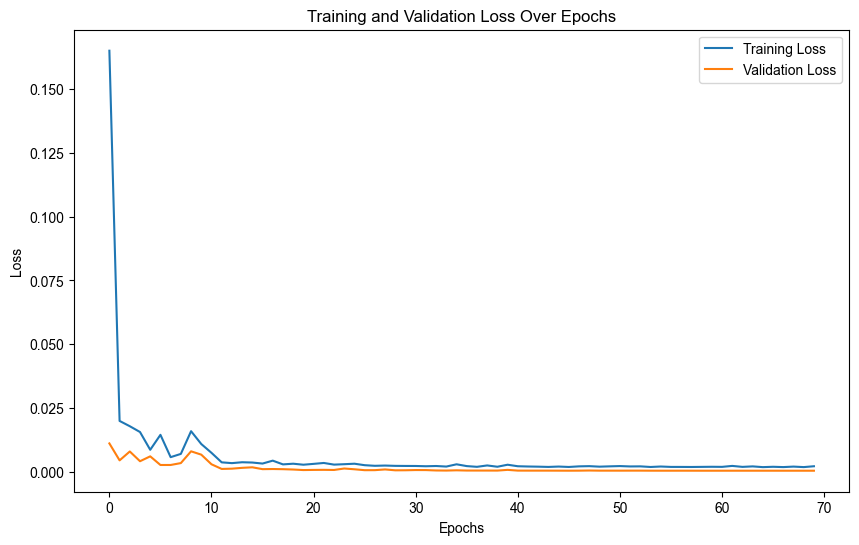

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_26 (Dense)            (None, 512)               3072      
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 5)                 645       
                                                                 
Total params: 167941 (656.02 KB)
Trainable params: 167941 

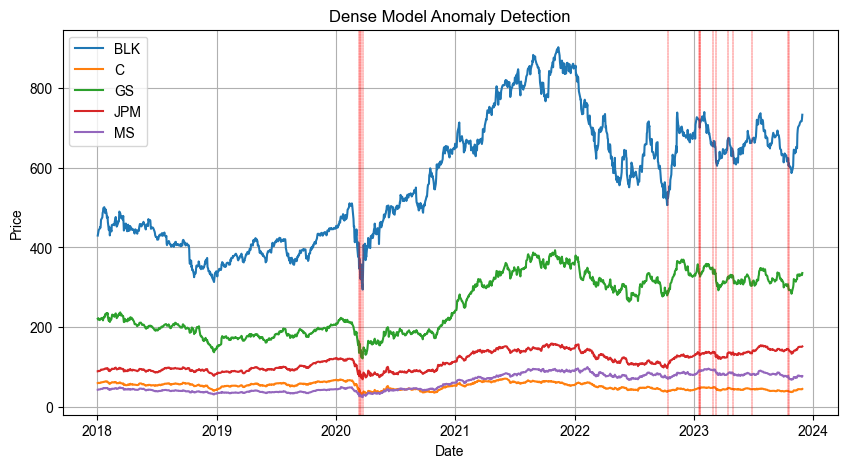

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-24,334.2,34.4,138.2,77.5,28.9
2022-10-14,525.1,40.1,285.1,106.1,70.4
2023-01-17,719.5,47.2,334.8,135.3,91.7
2023-01-19,700.4,46.3,335.6,129.5,88.9
2023-01-20,711.8,48.0,327.0,129.8,90.9
2023-03-01,653.1,48.8,333.6,137.0,91.6


In [65]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(42)

# Preprocess the data (Standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(delta.values.astype('float32'))
input_dim = data.shape[1]

# Define the Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dropout(0.1)(encoded)  # Add dropout for regularization
encoded = Dense(256, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = autoencoder.fit(data, data, epochs=100, batch_size=16, shuffle=True, 
                          validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Use the trained Autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(data)

# Calculate reconstruction errors
mse = np.mean(np.power(data - reconstructed_data, 2), axis=1)

# Set anomaly threshold to 99th percentile
threshold = np.percentile(mse, 99)

# Detect anomalies
anomalies = mse > threshold

# Add anomalies to original DataFrame
delta_autoencoder = delta.copy()
delta_autoencoder['Anomaly'] = anomalies.astype(int)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('Figs/dense loss epoch.jpg')
plt.show()

autoencoder.summary()
# Print anomalies


dense_indx = delta_autoencoder[delta_autoencoder['Anomaly'] == 1].index

# Plot anomalies detected by Dense model
plot_anomalies(stocks, dense_indx, title="Dense Model Anomaly Detection" , save_loc = 'Figs/Dense anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(dense_indx)].round(1)



### 4.9. LSTM Autoencoder Anomaly Detection Algorithm

The LSTM Autoencoder is an effective method for detecting anomalies in time series data by learning to reconstruct normal patterns and identifying deviations. The process involves reshaping time series data into a 3D array (samples, timesteps, and features) to fit the LSTM network.

1. **Architecture**:
   - **Encoder**: Reduces the time series data to a latent space representation $ Z $.
   - **Decoder**: Reconstructs the input data from the latent space representation.

2. **Mathematical Formulation**:
   - Encoder: $ Z = \text{LSTM}_{\text{encoder}}(\Delta) $
   - Decoder: $ \hat{\Delta} = \text{LSTM}_{\text{decoder}}(Z) $

3. **Training**: The model is trained to minimize the mean squared error (MSE) between the input $ \Delta $ and the reconstructed output $ \hat{\Delta} $. The loss is computed as:
   $
   \text{Loss} = \frac{1}{T \times F} \sum_{t=1}^{T} \sum_{f=1}^{F} (\Delta_{t,f} - \hat{\Delta}_{t,f})^2
   $

4. **Anomaly Detection**: After training, the reconstruction error is calculated for each sample. A predefined threshold is applied, and any sample with an error exceeding the threshold is flagged as an anomaly.

5. **Steps**:
   - **Encoding**: The input sequence is processed by the encoder LSTM to produce $ Z $.
   - **Decoding**: $ Z $ is decoded back to $ \hat{\Delta} $ using the decoder LSTM.
   - **Reconstruction Error**: MSE is computed for each sample.
   - **Thresholding**: Anomalies are detected if MSE exceeds a threshold.

   Anomalies are shown in below Table and Figure.

Epoch 1/50
75/75 [==============================] - 2s 6ms/step - loss: 0.9418 - val_loss: 0.4646
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 0.4417 - val_loss: 0.2625
Epoch 3/50
75/75 [==============================] - 0s 5ms/step - loss: 0.2618 - val_loss: 0.1940
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1837 - val_loss: 0.1456
Epoch 5/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1379 - val_loss: 0.1248
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.1074 - val_loss: 0.0952
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0743
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0573
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0469
Epoch 10/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0390
Epoch 11/50
75/75 [

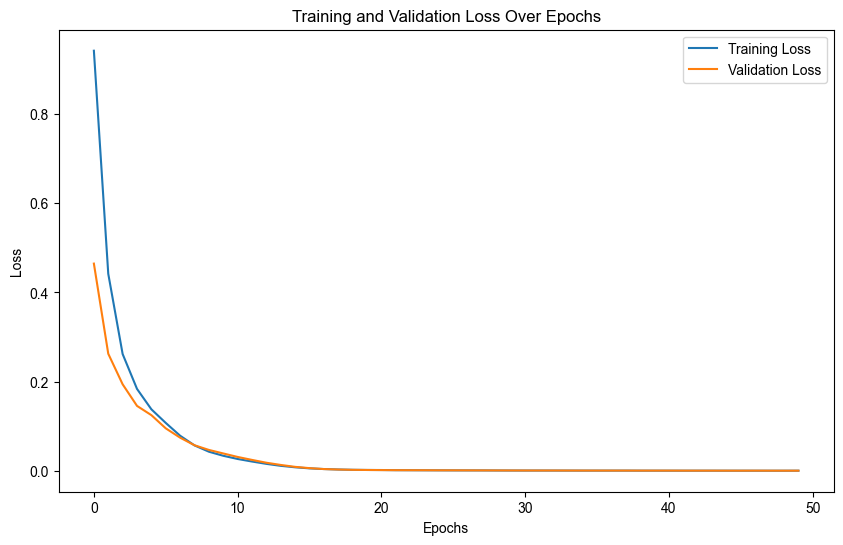

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 5)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               68608     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 1, 128)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 1, 5)              2680      
                                                                 
Total params: 71288 (278.47 KB)
Trainable params: 71288 (278.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


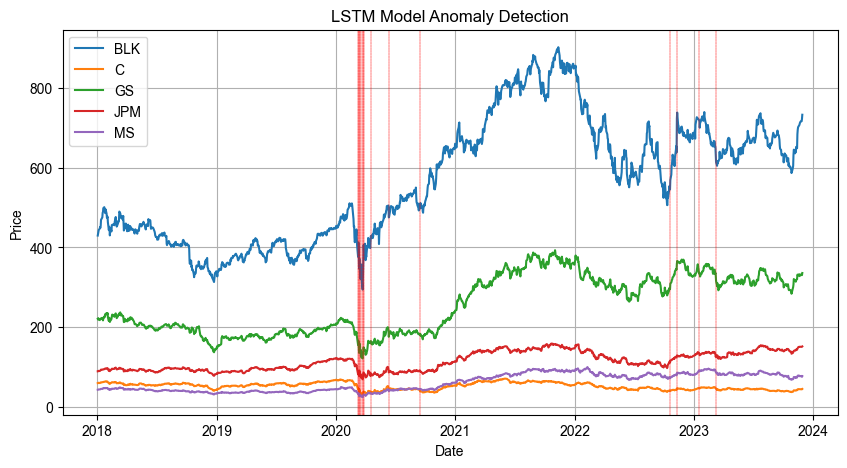

,BLK,C,GS,JPM,MS
Date,,,,,
2020-03-09,376.7,43.5,155.5,81.9,32.7
2020-03-12,347.2,36.7,135.6,77.2,27.3
2020-03-13,372.0,43.2,159.4,91.1,32.7
2020-03-16,321.2,34.9,139.2,77.4,27.6
2020-03-18,335.6,30.9,126.0,73.5,26.8
2020-03-23,294.3,30.0,121.5,69.3,24.2
2020-03-24,334.2,34.4,138.2,77.5,28.9
2020-03-26,406.2,39.0,149.2,86.0,31.1
2020-04-17,428.7,38.5,165.1,84.3,34.0


In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector


# Prepare the data
data = delta.values.astype('float32')

# Reshape data to 3D for LSTM input: (samples, timesteps, features)
timesteps = 1 
data = data.reshape((data.shape[0], timesteps, data.shape[1]))

# Define the Autoencoder architecture
input_layer = Input(shape=(timesteps, data.shape[2]))
encoded = LSTM(128, activation='relu', return_sequences=False)(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(data.shape[2], activation='linear', return_sequences=True)(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the Autoencoder and capture the training history
history = autoencoder.fit(data, data, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

# Use the trained Autoencoder to reconstruct the input data
reconstructed_data = autoencoder.predict(data)

# Reshape reconstructed data back to 2D for error calculation
reconstructed_data = reconstructed_data.reshape((reconstructed_data.shape[0], reconstructed_data.shape[2]))
data_2d = data.reshape((data.shape[0], data.shape[2]))

# Calculate reconstruction errors
mse = np.mean(np.power(data_2d - reconstructed_data, 2), axis=1)

# Set anomaly threshold to 99th percentile
threshold = np.percentile(mse, 99)

# Detect anomalies
anomalies = mse > threshold

# Add anomalies to original DataFrame
delta_autoencoder = delta.copy()
delta_autoencoder['Anomaly'] = anomalies.astype(int)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('Figs/lstm_loss_epoch.jpg')
plt.show()

autoencoder.summary()
# Print anomalies

lstm_indx = delta_autoencoder[delta_autoencoder['Anomaly'] == 1].index

# Plot anomalies detected by LSTM model
plot_anomalies(stocks, lstm_indx, title="LSTM Model Anomaly Detection" , save_loc = 'Figs/lstm anomalies.jpg')

# Display the numerical values of the anomalies
stocks.loc[stocks.index.isin(lstm_indx)].round(1)


# 5. Business-Centric Questions Explored
## 5.1. Can Statistical Anomaly Detection Methods Deliver Reliable Results?
In the analysis, we compared the results of eight anomaly detection methods used in this study. The findings indicate that the similarity scores across all statistical methods are within a close range (from 4.61 to 5.06), suggesting consistency in their detection capabilities.

## 5.2. Is Machine Learning Worth the Investment for Anomaly Detection?
The results presented show that the similarity scores for machine learning-based methods exhibit significant variation, with the highest score achieved by the Isolation Forest and the lowest by the dense neural network model. However, enhancements to the dense model, such as incorporating LSTM layers, led to improved similarity scores. This suggests that while ML-based approaches come with higher computational costs, they can deliver superior results when properly optimized.

In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Assuming these are provided DatetimeIndex objects
datetime_indexes = {
    'iqr_result_indx': iqr_result_indx,
    'mad_result_indx': mad_result_indx,
    'parametric_model_result_inx': parametric_model_result_inx,
    'kalman_result_indx': kalman_result_indx,
    'knn_indx': knn_indx,
    'if_indx': if_indx,
    'dense_indx': dense_indx,
    'lstm_indx': lstm_indx
}

# Convert DatetimeIndexes to sorted arrays of integers (timestamps)
timestamp_arrays = {k: np.array(v.astype(np.int64)) for k, v in datetime_indexes.items()}

# Create a matrix to hold pairwise distance measures
methods = list(timestamp_arrays.keys())
num_methods = len(methods)
distance_matrix = np.zeros((num_methods, num_methods))

# Calculate average distance between each pair of methods
for i in range(num_methods):
    for j in range(num_methods):
        if i != j:
            distances = euclidean_distances(
                timestamp_arrays[methods[i]].reshape(-1, 1), 
                timestamp_arrays[methods[j]].reshape(-1, 1)
            )
            # Take mean distance as a measure of closeness between the two methods
            distance_matrix[i, j] = np.mean(distances)

# Convert distance matrix to similarity matrix (smaller distances => higher similarity)
max_distance = np.max(distance_matrix)
similarity_matrix = 1 - (distance_matrix / max_distance)

# Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=methods, columns=methods)

# Display the similarity matrix
print("Similarity Matrix Based on Date Closeness:")
similarity_df['total_similarity_score'] = similarity_df.sum(axis=1)
# Sort by total similarity score
similarity_df_sorted = similarity_df.sort_values(by='total_similarity_score', ascending=False)
similarity_df_sorted

Similarity Matrix Based on Date Closeness:


,iqr_result_indx,mad_result_indx,parametric_model_result_inx,kalman_result_indx,knn_indx,if_indx,dense_indx,lstm_indx,total_similarity_score
if_indx,0.799691,0.783254,0.688945,0.758003,0.784470,1.000000,3.774758e-15,0.631095,5.445457
iqr_result_indx,1.000000,0.676528,0.605898,0.657678,0.684815,0.799691,6.810046e-02,0.568648,5.061359
knn_indx,0.684815,0.662572,0.593943,0.644381,1.000000,0.784470,7.394047e-02,0.559695,5.003816
mad_result_indx,0.676528,1.000000,0.586888,0.639195,0.662572,0.783254,2.087996e-02,0.540322,4.909639
kalman_result_indx,0.657678,0.639195,0.570138,1.000000,0.644381,0.758003,3.687125e-02,0.529665,4.835930
parametric_model_result_inx,0.605898,0.586888,1.000000,0.570138,0.593943,0.688945,6.813895e-02,0.496758,4.610710
lstm_indx,0.568648,0.540322,0.496758,0.529665,0.559695,0.631095,1.468526e-01,1.000000,4.473035
dense_indx,0.068100,0.020880,0.068139,0.036871,0.073940,0.000000,1.000000e+00,0.146853,1.414784
